# Arima Models for California Counties 

In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import random

In [2]:
data = pd.read_csv('finalized_county.csv')

In [3]:
california_data = data[data['state'] == 'California']
california_data['date'] = pd.to_datetime(california_data['date'], format="%Y-%m-%d")
california_data['county'].unique()

array(['Los Angeles', 'Orange', 'San Diego'], dtype=object)

# Los Angeles

In [4]:
la = california_data[california_data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Los Angeles is non-stationary
print("Stationary or not?:", stationary_test(la.incremental_cases))

# get this value for reversion purposes
print(la.loc[la['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
la['incremental_cases'] = la['incremental_cases'].diff(
).fillna(la['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(la.incremental_cases))

# get this value for reversion purposes
print(la.loc[la['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
la['incremental_cases'] = la['incremental_cases'].diff(
).fillna(la['incremental_cases']).astype('int')

# Los Angeles is stationary after second-level differencing
print("Stationary after second level diff?:", stationary_test(la.incremental_cases))

Stationary or not?: (1.3190762222252403, 0.9967136380720155)
229    823
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-0.934092662079519, 0.7765380334868845)
229   -1293
Name: incremental_cases, dtype: int64
Stationary after second level diff?: (-8.591013100393987, 7.286147751265899e-14)


In [5]:
la.shape

(270, 2)

In [6]:
# use 85%-15% for train-test split
train = la.iloc[:230, :]
test = la.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

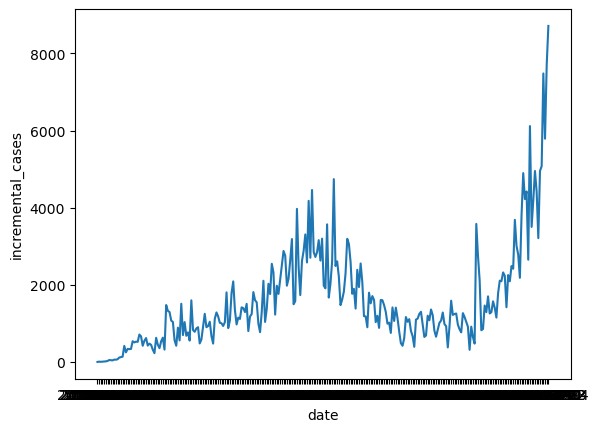

In [7]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [9]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3]
d_values = [2]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [2]
Q_values = [0, 1, 2, 3]
m_values = [30]  

# Generate all possible combinations of parameters
all_combinations = [(p, d, q, P, D, Q, m) for p in p_values for d in d_values for q in q_values
                    for P in P_values for D in D_values for Q in Q_values for m in m_values]

# Randomize
random.shuffle(all_combinations)

# Limit the number of iterations
max_iterations = 20  
limited_combinations = all_combinations[:max_iterations]

best_score, best_cfg = float("inf"), None

# Iterate through the randomized/limited combinations of parameters
for (p, d, q, P, D, Q, m) in limited_combinations:
    mse_scores = []

    for train_index, val_index in tscv.split(train):
        try:
            train_data, val_data = train.loc[train_index], train.loc[val_index]
            model = SARIMAX(train_data.incremental_cases,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=len(val_data))
            mse = mean_squared_error(val_data.incremental_cases, forecast)
            mse_scores.append(mse)
        except:
            mse_scores.append(float("inf"))  # In case the model fitting fails

    average_mse = np.mean(mse_scores)
    if average_mse < best_score:
        best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')


Best SARIMA parameters: ((2, 2, 3), (2, 2, 3, 30)) with MSE: 2325028235.708943


In [12]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(2, 2, 3) , seasonal_order=(2, 2, 3, 30)).fit()
pred = pd.concat([pd.Series([-1293]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([823]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29787D+00    |proj g|=  1.07989D+00


 This problem is unconstrained.



At iterate    5    f=  6.66277D+00    |proj g|=  1.90443D-02

At iterate   10    f=  6.64023D+00    |proj g|=  4.17645D-03

At iterate   15    f=  6.63941D+00    |proj g|=  3.00855D-04

At iterate   20    f=  6.63939D+00    |proj g|=  3.92673D-04

At iterate   25    f=  6.63896D+00    |proj g|=  6.09321D-03

At iterate   30    f=  6.63799D+00    |proj g|=  7.16098D-04

At iterate   35    f=  6.63794D+00    |proj g|=  7.57709D-04

At iterate   40    f=  6.63778D+00    |proj g|=  3.33130D-04

At iterate   45    f=  6.63749D+00    |proj g|=  1.72012D-03

At iterate   50    f=  6.63490D+00    |proj g|=  2.31997D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [11]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [1, 2, 3]
d_values = [2]
q_values = [2, 3]

# Seasonal parameters
P_values = [2, 3]  
D_values = [2]  
Q_values = [2, 3]  
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((3, 2, 2), (2, 2, 2, 30)) with MSE: 2324205839.976543


In [13]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 2, 2) , seasonal_order=(2, 2, 2, 30)).fit()
pred = pd.concat([pd.Series([-1293]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([823]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99007D+00    |proj g|=  7.69963D-01

At iterate    5    f=  6.57011D+00    |proj g|=  2.36874D-02

At iterate   10    f=  6.53262D+00    |proj g|=  5.30629D-02

At iterate   15    f=  6.51907D+00    |proj g|=  3.72937D-03

At iterate   20    f=  6.51411D+00    |proj g|=  6.77997D-03

At iterate   25    f=  6.51362D+00    |proj g|=  2.77719D-04

At iterate   30    f=  6.51344D+00    |proj g|=  1.68694D-03

At iterate   35    f=  6.51338D+00    |proj g|=  6.16599D-04

At iterate   40    f=  6.51318D+00    |proj g|=  3.82567D-03

At iterate   45    f=  6.51296D+00    |proj g|=  8.46256D-04

At iterate   50    f=  6.51290D+00    |proj g|=  4.46073D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [8]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 2, 3) , seasonal_order=(1, 2, 3, 30)).fit()
pred = pd.concat([pd.Series([-1293]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([823]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29779D+00    |proj g|=  1.41369D+00


 This problem is unconstrained.



At iterate    5    f=  6.50270D+00    |proj g|=  5.54959D-02

At iterate   10    f=  6.43157D+00    |proj g|=  3.13678D-02

At iterate   15    f=  6.41099D+00    |proj g|=  4.81108D-03

At iterate   20    f=  6.40845D+00    |proj g|=  8.65568D-03

At iterate   25    f=  6.40300D+00    |proj g|=  1.86222D-02

At iterate   30    f=  6.40121D+00    |proj g|=  5.67057D-03

At iterate   35    f=  6.40049D+00    |proj g|=  5.59740D-03

At iterate   40    f=  6.39769D+00    |proj g|=  5.74103D-03

At iterate   45    f=  6.39741D+00    |proj g|=  4.38766D-04

At iterate   50    f=  6.39726D+00    |proj g|=  4.05259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

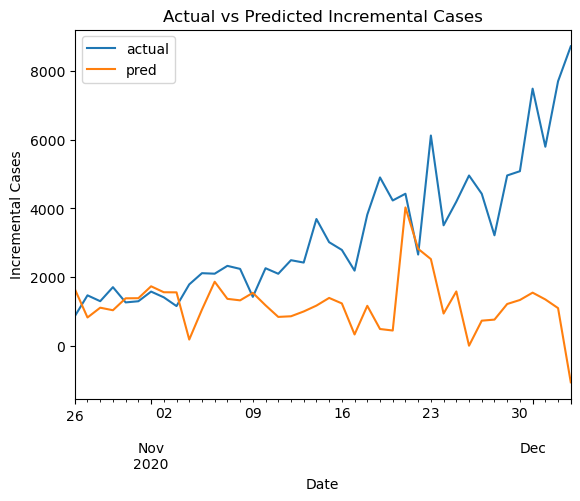

In [9]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  incremental_cases   No. Observations:                  230
Model:             SARIMAX(3, 2, 3)x(1, 2, 3, 30)   Log Likelihood               -1471.369
Date:                            Sat, 09 Mar 2024   AIC                           2964.739
Time:                                    00:27:01   BIC                           2999.102
Sample:                                         0   HQIC                          2978.685
                                            - 230                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4567      0.580     -0.788      0.431      -1.593       0.679
ar.L2         -0.2515      0.628     -0.400      0.689      -1.483       0.980
ar.L3         -0.2383      0.490     -0.486      0.627      -1.199       0.723
ma.L1         -2.8076      0.507     -5.539      0.000      -3.801      -1.814
ma.L2          2.6340      1.024      2.573      0.010       0.628       4.640
ma.L3         -0.8248      0.528     -1.562      0.118      -1.859       0.210
ar.S.L30       0.0746     21.607      0.003      0.997     -42.274      42.423
ma.S.L30      -0.9789     21.878     -0.045      0.964     -43.859      41.901
ma.S.L60       0.4531     19.433      0.023      0.981     -37.635      38.541
ma.S.L90      -0.1038      8.709     -0.012      0.990     -17.173      16.965
sigma2      4.809e+06      0.000   1.27e+10      0.000    4.81e+06    4.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                 5.64
Prob(Q):                              0.29   Prob(JB):                         0.06
Heteroskedasticity (H):               2.07   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+26. Standard errors may be unstable.
"""

# Orange

In [14]:
orange = california_data[california_data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
orange['incremental_cases'] = orange['incremental_cases'].astype('int')
orange['date'] = pd.to_datetime(orange['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange is non-stationary
print("Stationary or not?:", stationary_test(orange.incremental_cases))

# get this value for reversion purposes
print(orange.loc[orange['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
orange['incremental_cases'] = orange['incremental_cases'].diff(
).fillna(orange['incremental_cases']).astype('int')

# Los Angeles is non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(orange.incremental_cases))

Stationary or not?: (-0.1897980045327783, 0.9397267929055788)
499    247
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-10.476734705085976, 1.243438566263163e-18)


In [15]:
orange.shape

(270, 2)

In [16]:
# use 85%-15% for train-test split
train = orange.iloc[:230, :]
test = orange.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

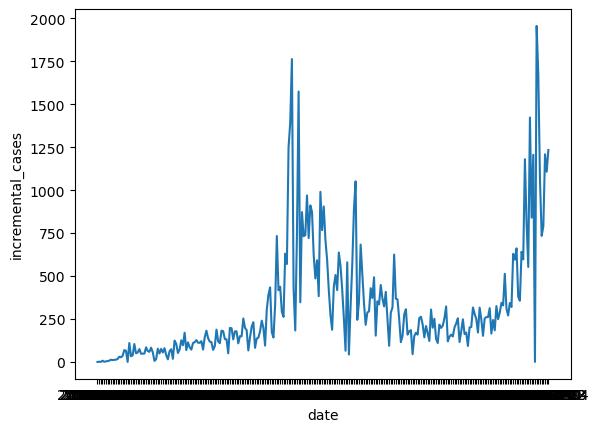

In [17]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [18]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3]
d_values = [1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [1]
Q_values = [0, 1, 2, 3]
m_values = [30]  

# Generate all possible combinations of parameters
all_combinations = [(p, d, q, P, D, Q, m) for p in p_values for d in d_values for q in q_values
                    for P in P_values for D in D_values for Q in Q_values for m in m_values]

# Randomize
random.shuffle(all_combinations)

# Limit the number of iterations
max_iterations = 20  
limited_combinations = all_combinations[:max_iterations]

best_score, best_cfg = float("inf"), None

# Iterate through the randomized/limited combinations of parameters
for (p, d, q, P, D, Q, m) in limited_combinations:
    mse_scores = []

    for train_index, val_index in tscv.split(train):
        try:
            train_data, val_data = train.loc[train_index], train.loc[val_index]
            model = SARIMAX(train_data.incremental_cases,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=len(val_data))
            mse = mean_squared_error(val_data.incremental_cases, forecast)
            mse_scores.append(mse)
        except:
            mse_scores.append(float("inf"))  # In case the model fitting fails

    average_mse = np.mean(mse_scores)
    if average_mse < best_score:
        best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((3, 1, 1), (0, 1, 2, 30)) with MSE: 63832.34324069682


In [19]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 1, 1), seasonal_order=(0,1,2,30)).fit()
pred = pd.concat([pd.Series([247]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24549D+00    |proj g|=  3.44237D-01


 This problem is unconstrained.



At iterate    5    f=  6.08644D+00    |proj g|=  2.73787D-02

At iterate   10    f=  6.07330D+00    |proj g|=  4.59898D-03

At iterate   15    f=  6.07248D+00    |proj g|=  2.23592D-03

At iterate   20    f=  5.96640D+00    |proj g|=  1.81919D-01

At iterate   25    f=  5.87823D+00    |proj g|=  2.10438D-02

At iterate   30    f=  5.87323D+00    |proj g|=  4.64220D-03

At iterate   35    f=  5.87284D+00    |proj g|=  9.19612D-04

At iterate   40    f=  5.87278D+00    |proj g|=  2.76662D-04

At iterate   45    f=  5.87277D+00    |proj g|=  7.52436D-04

At iterate   50    f=  5.87277D+00    |proj g|=  2.86179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<Axes: xlabel='date'>

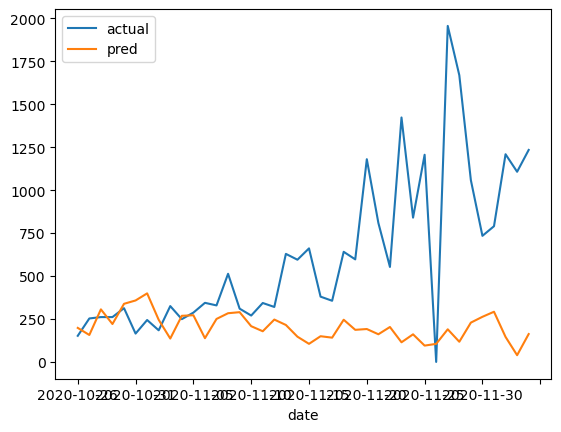

In [20]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [21]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [2, 3]
d_values = [1]
q_values = [1, 2, 3]

# Seasonal parameters
P_values = [0, 1, 2, 3]  
D_values = [1]  
Q_values = [2, 3]  
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((3, 1, 1), (0, 1, 2, 30)) with MSE: 63832.34324069682


Got same results as random grid search

In [22]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 1, 1), seasonal_order=(0,1,2,30)).fit()
pred = pd.concat([pd.Series([247]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24549D+00    |proj g|=  3.44237D-01


 This problem is unconstrained.



At iterate    5    f=  6.08644D+00    |proj g|=  2.73787D-02

At iterate   10    f=  6.07330D+00    |proj g|=  4.59898D-03

At iterate   15    f=  6.07248D+00    |proj g|=  2.23592D-03

At iterate   20    f=  5.96640D+00    |proj g|=  1.81919D-01

At iterate   25    f=  5.87823D+00    |proj g|=  2.10438D-02

At iterate   30    f=  5.87323D+00    |proj g|=  4.64220D-03

At iterate   35    f=  5.87284D+00    |proj g|=  9.19612D-04

At iterate   40    f=  5.87278D+00    |proj g|=  2.76662D-04

At iterate   45    f=  5.87277D+00    |proj g|=  7.52436D-04

At iterate   50    f=  5.87277D+00    |proj g|=  2.86179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

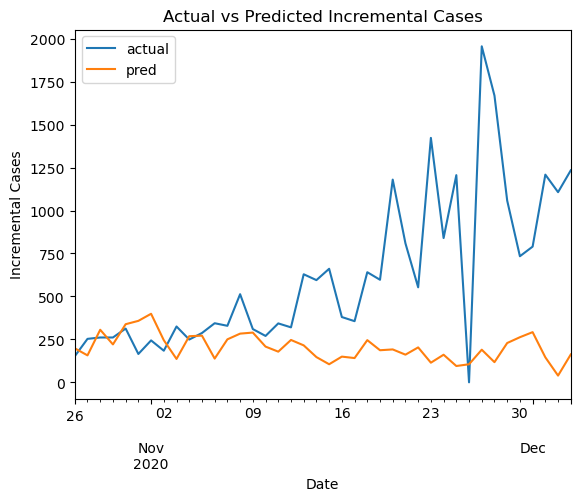

In [23]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()

# San Diego

In [28]:
sandiego = california_data[california_data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
sandiego['incremental_cases'] = sandiego['incremental_cases'].astype('int')
sandiego['date'] = pd.to_datetime(sandiego['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# San Diego is non-stationary
print("Stationary or not?:", stationary_test(sandiego.incremental_cases))

# get this value for reversion purposes
print(sandiego.loc[sandiego['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff(
).fillna(sandiego['incremental_cases']).astype('int')

# San Diego is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(sandiego.incremental_cases))

# get this value for reversion purposes
print(sandiego.loc[sandiego['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff(
).fillna(sandiego['incremental_cases']).astype('int')

# San Diego is stationary after second-level differencing
print("Stationary after second level diff?:", stationary_test(sandiego.incremental_cases))

Stationary or not?: (0.6357611259888307, 0.9884647007943559)
769    269
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-1.5064452750852018, 0.5303205781258837)
769   -117
Name: incremental_cases, dtype: int64
Stationary after second level diff?: (-7.545305190841254, 3.2955778088676166e-11)


In [29]:
sandiego.shape

(270, 2)

In [30]:
# use 85%-15% for train-test split
train = sandiego.iloc[:230, :]
test = sandiego.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

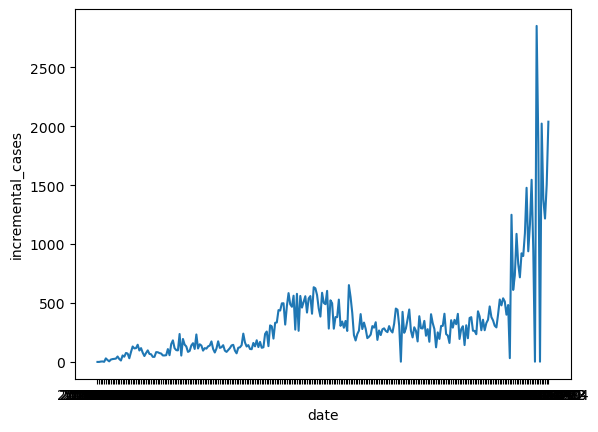

In [31]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [32]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3]
d_values = [2]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [2]
Q_values = [0, 1, 2, 3]
m_values = [30]  

# Generate all possible combinations of parameters
all_combinations = [(p, d, q, P, D, Q, m) for p in p_values for d in d_values for q in q_values
                    for P in P_values for D in D_values for Q in Q_values for m in m_values]

# Randomize
random.shuffle(all_combinations)

# Limit the number of iterations
max_iterations = 30  
limited_combinations = all_combinations[:max_iterations]

best_score, best_cfg = float("inf"), None

# Iterate through the randomized/limited combinations of parameters
for (p, d, q, P, D, Q, m) in limited_combinations:
    mse_scores = []

    for train_index, val_index in tscv.split(train):
        try:
            train_data, val_data = train.loc[train_index], train.loc[val_index]
            model = SARIMAX(train_data.incremental_cases,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=len(val_data))
            mse = mean_squared_error(val_data.incremental_cases, forecast)
            mse_scores.append(mse)
        except:
            mse_scores.append(float("inf"))  # In case the model fitting fails

    average_mse = np.mean(mse_scores)
    if average_mse < best_score:
        best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((2, 2, 3), (0, 2, 0, 30)) with MSE: 17607764.490240835


In [33]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(2, 2, 3), seasonal_order=(0,2,0,30)).fit()
pred = pd.concat([pd.Series([269]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([-117]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31035D+00    |proj g|=  3.80437D+00


 This problem is unconstrained.



At iterate    5    f=  5.49978D+00    |proj g|=  1.06888D-01

At iterate   10    f=  5.39322D+00    |proj g|=  3.32132D-02

At iterate   15    f=  5.34172D+00    |proj g|=  2.82341D-02

At iterate   20    f=  5.32875D+00    |proj g|=  1.54999D-03

At iterate   25    f=  5.32478D+00    |proj g|=  7.74513D-03

At iterate   30    f=  5.25049D+00    |proj g|=  3.05294D-02

At iterate   35    f=  5.13799D+00    |proj g|=  8.07672D-02

At iterate   40    f=  5.12397D+00    |proj g|=  2.31448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     69      1     0     0   2.657D-04   5.124D+00
  F =   5.12397376968

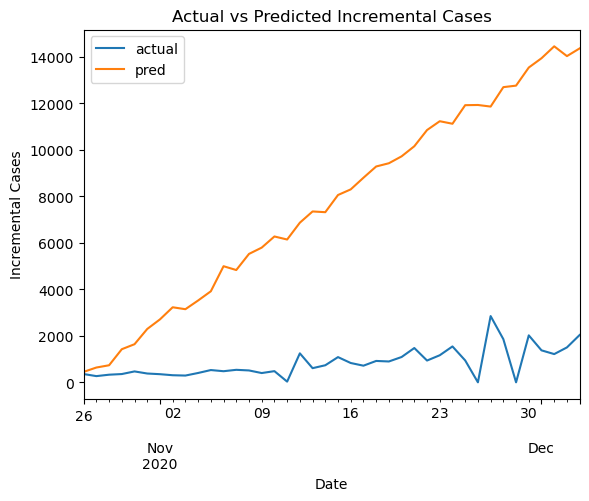

In [34]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()

In [35]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [1, 2, 3]
d_values = [2]
q_values = [2, 3]

# Seasonal parameters
P_values = [0, 1, 2]  
D_values = [2]  
Q_values = [0, 1, 2]
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((1, 2, 2), (0, 2, 0, 30)) with MSE: 17568208.640713032


In [37]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(1, 2, 2), seasonal_order=(0,2,0,30)).fit()
pred = pd.concat([pd.Series([269]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([-117]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57046D+00    |proj g|=  6.27253D-02


 This problem is unconstrained.



At iterate    5    f=  5.51334D+00    |proj g|=  2.09381D-03

At iterate   10    f=  5.41362D+00    |proj g|=  1.94743D-02

At iterate   15    f=  5.38564D+00    |proj g|=  2.25158D-04

At iterate   20    f=  5.38563D+00    |proj g|=  5.53234D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     60      1     0     0   1.442D-02   5.382D+00
  F =   5.3818577530621416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
R-squared -142.48819831952488


<Axes: xlabel='date'>

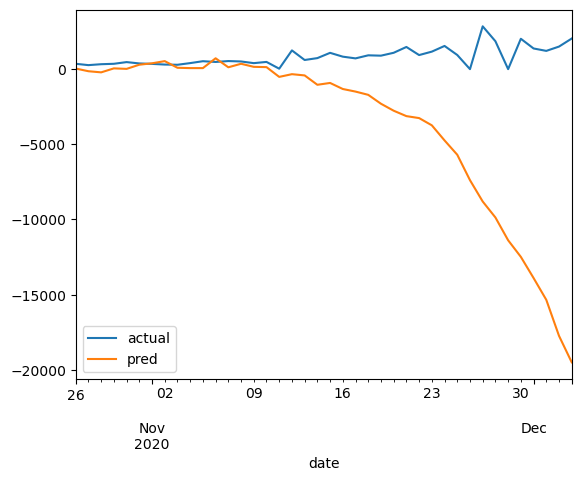

In [38]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [39]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [0, 1, 2, 3]
d_values = [2]
q_values = [0, 1, 2, 3]

# Seasonal parameters
P_values = [0, 1, 2]  
D_values = [2]  
Q_values = [0, 1, 2]
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((1, 2, 2), (0, 2, 0, 30)) with MSE: 17568208.640713032


In [40]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(1, 2, 2), seasonal_order=(0,2,0,30)).fit()
pred = pd.concat([pd.Series([269]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([-117]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57046D+00    |proj g|=  6.27253D-02

At iterate    5    f=  5.51334D+00    |proj g|=  2.09381D-03

At iterate   10    f=  5.41362D+00    |proj g|=  1.94743D-02

At iterate   15    f=  5.38564D+00    |proj g|=  2.25158D-04

At iterate   20    f=  5.38563D+00    |proj g|=  5.53234D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     60      1     0     0   1.442D-02   5.382D+00
  F =   5.3818577530621416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
R-squared -142.48819831952488


<Axes: xlabel='date'>

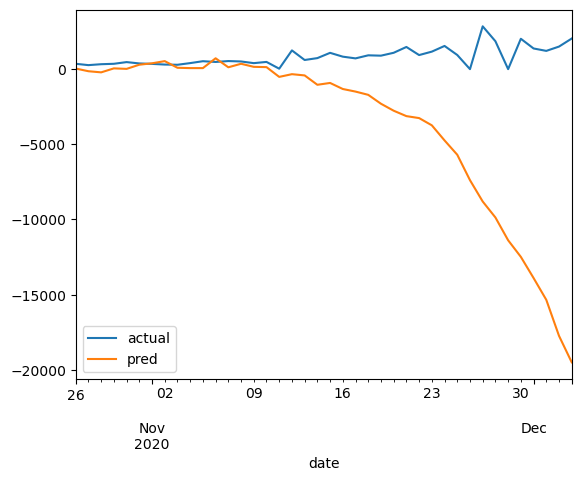

In [41]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   incremental_cases   No. Observations:                  230
Model:             SARIMAX(1, 2, 2)x(0, 2, [], 30)   Log Likelihood               -1237.827
Date:                             Sat, 09 Mar 2024   AIC                           2483.655
Time:                                     14:56:13   BIC                           2496.150
Sample:                                          0   HQIC                          2488.726
                                             - 230                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6949      0.036    -19.124      0.000      -0.766      -0.624
ma.L1         -1.9955      0.065    -30.631      0.000      -2.123      -1.868
ma.L2          0.9998      0.062     16.101      0.000       0.878       1.122
sigma2      1.221e+05   1.03e-06   1.18e+11      0.000    1.22e+05    1.22e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.64   Jarque-Bera (JB):                73.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.90   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+26. Standard errors may be unstable.
"""